### Installs

In [1]:
%pip install ultralytics 

Note: you may need to restart the kernel to use updated packages.


In [92]:
%pip install pyzbar

   ---------------------------------------- 0.0/817.4 kB ? eta -:--:--
   ---------------------------------------- 817.4/817.4 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Imports

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.yolo as fouy
from ultralytics import YOLO
import random
import os
import shutil
from fiftyone import ViewField as F
import glob
import cv2
import numpy as np
from pyzbar.pyzbar import decode

fo.types.YOLOv5Dataset

fiftyone.types.dataset_types.YOLOv5Dataset

### Data prep

In [3]:
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    classes=["Box"]
)

sample = dataset.first()
sample

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v6-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


<Sample: {
    'id': '696798668eedb29fcff28c5d',
    'media_type': 'image',
    'filepath': 'C:\\Users\\raian\\fiftyone\\open-images-v6\\train\\data\\0000333f08ced1cd.jpg',
    'tags': ['train'],
    'metadata': None,
    'created_at': datetime.datetime(2026, 1, 14, 13, 21, 42, 711000),
    'last_modified_at': datetime.datetime(2026, 1, 14, 13, 21, 42, 711000),
    'ground_truth': <Detections: {

        'detections': [

            <Detection: {


                'id': '696798668eedb29fcff28c5c',


                'attributes': {},


                'tags': [],


                'label': 'Box',


                'bounding_box': [


                    0.153206,


                    0.06875,


                    0.6977519999999999,


                    0.8825000000000001,


                ],


                'mask': array([[False, False, False, ..., False, False, False],


                       [False, False, False, ..., False, False, False],


                       [False, Fals

In [16]:
session = fo.launch_app(dataset)
session.wait()

Notebook sessions cannot wait


In [4]:
view = dataset.filter_labels(
    "ground_truth",
    F("label") == "Box"
)

view = view.match(F("ground_truth.detections").length() > 0)

print(f"Filtered view: {len(view)} samples with Box only")

classes = view.distinct("ground_truth.detections.label")
print(f"Classes: {classes}") 

Filtered view: 2086 samples with Box only
Classes: ['Box']


In [ ]:
import numpy as np
import cv2 as cv

def polygon_to_mask(label_path, img_shape):
    h, w = img_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    with open(label_path) as f:
        for line in f:
            parts = list(map(float, line.split()))
            cls = int(parts[0])
            coords = np.array(parts[1:]).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            coords = coords.astype(np.int32)

            cv.fillPoly(mask, [coords], 1)

    return mask

In [40]:
dataset = fo.Dataset.from_dir(
    dataset_dir="./custom_data",
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
    annotation_path="annotations/instances_default.json",
    image_path="images",
)
sample = custom_dataset.first()

for d in sample["ground_truth"].detections:
    print(d.label, "has mask:", d.mask is not None)

Ignoring unsupported parameter 'annotation_path' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
Ignoring unsupported parameter 'image_path' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
 100% |█████████████████████| 0/0 [1.6ms elapsed, ? remaining, ? samples/s]  


ValueError: Dataset is empty

In [13]:
dataset.merge_samples(custom_dataset)
print(len(dataset))
classes = view.distinct("ground_truth.detections.label")
print(f"Classes: {classes}")

Converting existing index 'filepath' to unique on dataset '2026.01.22.09.20.08.672043'


2194
Classes: ['Box']


In [14]:
export_dir = "./yolo_dataset"

sample_ids = list(view.values("id"))
random.seed(42)
random.shuffle(sample_ids)

split_idx = int(len(sample_ids) * 0.9)
train_ids = sample_ids[:split_idx]
val_ids = sample_ids[split_idx:]

train_view = view.select(train_ids)
val_view = view.select(val_ids)

print(f"\nTrain: {len(train_view)} samples")
print(f"Val: {len(val_view)} samples")

if not os.path.exists(export_dir):
    print("\nExporting train split")
    train_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="ground_truth",
        classes=["Box"],
        split="train",
        use_masks=True
    )

    print("Exporting val split")
    val_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="ground_truth",
        classes=["Box"],
        split="val",
        use_masks=True
    )



Train: 1974 samples
Val: 220 samples

Exporting train split
 100% |███████████████| 1974/1974 [1.4m elapsed, 0s remaining, 99.6 samples/s]       
Exporting val split
Directory './yolo_dataset' already exists; export will be merged with existing files
 100% |█████████████████| 220/220 [9.9s elapsed, 0s remaining, 48.3 samples/s]       


In [17]:
view = train_view.match(
    fo.ViewField("filepath").re_match(".*undistorted*.jpg$")
)

print("Custom images:", view.count())
print("Total images:", train_view.count())

Custom images: 1
Total images: 1974


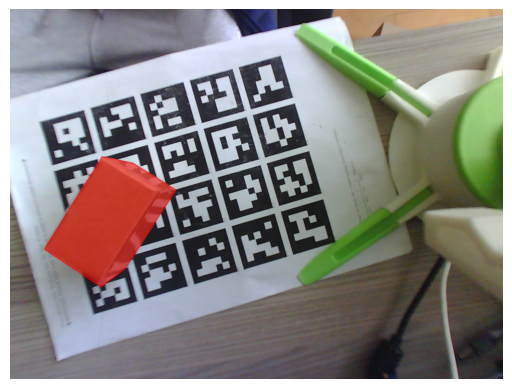

In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_path = "./yolo_dataset/images/train/undistorted_1.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

with open("./yolo_dataset/labels/train/undistorted_1.txt") as f:
    line = f.readline().strip().split()
coords = np.array(list(map(float, line[1:]))).reshape(-1,2)

h, w = img.shape[:2]
coords[:,0] *= w
coords[:,1] *= h

plt.imshow(img)
plt.fill(coords[:,0], coords[:,1], color='red', alpha=0.5)
plt.axis("off")
plt.show()

In [ ]:
# model = YOLO('yolo11s-seg.pt')

# results = model.train(
#     data=f"./yolo_dataset/dataset.yaml",
#     epochs=100,
#     imgsz=640,
#     batch=16,
#     name='box_segmentation'
# )
# print(results)

#through cmd:
#yolo segment train model=yolo11s-seg.pt data=yolo_dataset/dataset.yaml epochs=50 patience=20 device=0 batch=32 imgsz=640 workers=0

#second training:
#yolo segment train model=./runs/segment/train3/weights/best.pt data=additional_data/data.yaml epochs=10 device=0 batch=8 imgsz=640 workers=0

In [ ]:
image_paths = glob.glob("./custom_data/**/*.jpg", recursive=True)

model.predict(
    source=image_paths,
    save=True,
    save_txt=False,
    save_conf=False,
    conf=0.25,
    imgsz=640
)

print(image_paths)

KeyboardInterrupt: 

### Box detection and coordinate extraction

In [2]:
model = YOLO('runs/segment/train6/weights/best.pt')

In [3]:
# img = cv2.imread("./yolo_dataset/images/val/undistorted_34.jpg")
img = cv2.imread("./test_data/latest4.jpg")
result = model.predict(source=img)[0]
result.show()


0: 480x640 1 box, 250.7ms
Speed: 25.0ms preprocess, 250.7ms inference, 17.9ms postprocess per image at shape (1, 3, 480, 640)


In [57]:
mask = result.masks.xy[0]
len(mask)

57

In [ ]:
mask = result.masks.data[0].cpu().numpy()
mask = (mask * 255).astype(np.uint8)
scale = img.shape[0] / mask.shape[0]
mask = cv2.resize(
    mask,
    (int(mask.shape[1] * scale), int(mask.shape[0] * scale)),
    interpolation=cv2.INTER_NEAREST
)
contours, _ = cv2.findContours(
    mask,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE
)

contour = max(contours, key=cv2.contourArea)

epsilon = 0.012 * cv2.arcLength(contour, True)
polygon = cv2.approxPolyDP(contour, epsilon, True)
polygon = polygon.squeeze() 

In [72]:
overlay = img.copy()

color = np.array([255, 0, 0], dtype=np.uint8)

overlay[mask > 0] = (
    0.5 * overlay[mask > 0] + 0.5 * color
).astype(np.uint8)
cv2.polylines(overlay, [polygon.astype(np.int32)], True, (0,255,0), 2)

cv2.imwrite("result.png", overlay)

True

In [60]:
polygon

array([[558, 473],
       [545, 674],
       [904, 662],
       [889, 455],
       [580, 455]], dtype=int32)

In [61]:
polygon[(np.arange(len(polygon)) + 1) % len(polygon)]

array([[545, 674],
       [904, 662],
       [889, 455],
       [580, 455],
       [558, 473]], dtype=int32)

In [62]:
n = len(polygon)

In [63]:
edges = polygon[(np.arange(len(polygon)) + 1) % n] - polygon
edges

array([[ -13,  201],
       [ 359,  -12],
       [ -15, -207],
       [-309,    0],
       [ -22,   18]], dtype=int32)

In [64]:
directions = edges / np.linalg.norm(edges, axis=1, keepdims=True)
directions

array([[  -0.064542,     0.99792],
       [    0.99944,   -0.033408],
       [  -0.072274,    -0.99738],
       [         -1,           0],
       [   -0.77396,     0.63324]])

In [65]:
groups = []
singles = []
used = set()

for i, d in enumerate(directions):
    if i in used:
        continue
    group = [i]
    used.add(i)
    for j, dj in enumerate(directions):
        if j in used:
            continue
        if abs(d @ dj) > np.sin(np.radians(80)):
            group.append(j)
            used.add(j)
            
    if len(group) == 1:
        singles.append(group[0])
    else:
        groups.append(group)

print("Groups:", groups)
print("Singles:", singles)

Groups: [[0, 2], [1, 3]]
Singles: [4]


In [66]:
def line(p1, p2):
    return np.cross(
        np.array([p1[0], p1[1], 1.0]),
        np.array([p2[0], p2[1], 1.0])
    )

def intersect(l1, l2):
    p = np.cross(l1, l2)
    return p[:2] / p[2]

In [67]:
vanishing_points = []

for group in groups:
    i, j = group[:2]
    p1, p2 = polygon[i], polygon[(i+1)%n]
    p3, p4 = polygon[j], polygon[(j+1)%n]
    l1 = line(p1, p2)
    l2 = line(p3, p4)
    vanishing_points.append({"point": intersect(l1, l2), "single_points_left": set(range(0, n)) - set([i, (i+1)%n, j, (j+1)%n])})

vanishing_points

[{'point': array([     714.72,     -1950.1]), 'single_points_left': {4}},
 {'point': array([     7096.8,         455]), 'single_points_left': {0}}]

In [68]:
def clip_line_to_image(p, vp, w, h):
    l = np.cross(
        np.array([p[0], p[1], 1.0]),
        np.array([vp[0], vp[1], 1.0])
    )

    borders = [
        np.cross([0, 0, 1], [w, 0, 1]),
        np.cross([w, 0, 1], [w, h, 1]),
        np.cross([w, h, 1], [0, h, 1]),
        np.cross([0, h, 1], [0, 0, 1])
    ]

    pts = []
    for b in borders:
        p = np.cross(l, b)
        if abs(p[2]) < 1e-6:
            continue
        p = p[:2] / p[2]
        if 0 <= p[0] <= w and 0 <= p[1] <= h:
            pts.append(p)

    if len(pts) >= 2:
        return pts[0], pts[1]
    return None

In [70]:
h, w = img.shape[:2]

if len(singles) > 0:
    for vanishing_point in vanishing_points:
        for single_point_idx in vanishing_point["single_points_left"]:
            print("Drawing line from point", polygon[single_point_idx], "to vanishing point", vanishing_point["point"])
            seg = clip_line_to_image(polygon[single_point_idx], vanishing_point["point"], w, h)
            print(seg)
            p1, p2 = seg
            cv2.line(overlay, tuple(p1.astype(int)), tuple(p2.astype(int)), (0, 255, 0), 2)
        
    cv2.imwrite("result.png", overlay)

Drawing line from point [580 455] to vanishing point [     714.72     -1950.1]
None


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
from pyzbar.pyzbar import decode

img = cv2.imread("./test_data/latest4.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

qr = decode(gray)[0]
points = qr.polygon

n = len(points)
for i in range(n):
    pt1 = tuple(points[i])
    pt2 = tuple(points[(i + 1) % n])
    cv2.line(img, pt1, pt2, (0, 255, 0), 2)
data = qr.data.decode()
print(data)
    
cv2.imwrite("result.png", img)

package_1234


True

In [ ]:
#4 corners
top_side = polygon
top_side = top_side.astype(np.float32).reshape(-1, 1, 2)  # shape (N,1,2)

camera_matrix = np.load("../camera_matrix.npy")
dist_coeffs = np.load("../dist_coeffs.npy")
undistorted = cv2.undistortPoints(top_side, camera_matrix, dist_coeffs, P=camera_matrix)
undistorted = undistorted.reshape(-1, 2)  # back to (N,2)

h, w = img.shape[:2]
center = np.array([w/2, h/2])
distances = np.linalg.norm(undistorted - center, axis=1)
closest_idx = np.argmin(distances)
p_closest = undistorted[closest_idx]
closest_idx

np.int64(2)

In [ ]:
p_h = np.array([p_closest[0], p_closest[1], 1.0])
Kinv = np.linalg.inv(camera_matrix)
ray_cam = Kinv @ p_h
ray_cam = ray_cam / np.linalg.norm(ray_cam)

In [ ]:
from camera_utils import get_camera_position, get_marker_positions
MARKER_SIZE=0.036
MARKER_SPACING=0.005
QR_CODE_SIZE = 0.023

_, camera_position, _, R = get_camera_position(img, get_marker_positions(MARKER_SIZE, MARKER_SPACING), MARKER_SIZE)
R_wc = R.T
ray_world = R_wc @ ray_cam

# 3. Intersect with Z=0 plane in world frame
Z_plane = 0
if ray_world[2] != 0:
    scale = (Z_plane - camera_position[2]) / ray_world[2]
    point_3D = camera_position + scale * ray_world
    print("3D world coordinates at Z=0:", point_3D)
else:
    print("Ray is parallel to plane Z=0")

Reprojection error: 2.0841656
4.57670421403295
3D world coordinates at Z=0: [    0.11846    0.081569           0]


In [ ]:
qr_code_2d = qr.polygon.reshape(-1,1,2)
qr_code_undist = cv2.undistortPoints(qr_code_2d, camera_matrix, dist_coeffs, P=camera_matrix)
qr_code_undist = qr_code_undist.reshape(-1,2)

Kinv = np.linalg.inv(camera_matrix)

rays = []
for p in qr_code_undist:
    p_h = np.array([p[0], p[1], 1.0])
    ray_cam = Kinv @ p_h
    ray_cam /= np.linalg.norm(ray_cam)
    ray = R.T @ ray_cam
    rays.append(ray)

rays = np.array(rays)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
d0 = rays[0]
d1 = rays[1]

K_factor = np.linalg.norm(
    d1 / d1[2] - d0 / d0[2]
)

H1 = camera_position[2] + QR_CODE_SIZE / K_factor
H2 = camera_position[2] - QR_CODE_SIZE / K_factor

H = H1 if H1 > 0 else H2

print("Face height H: ", H)

### Full code

In [2]:
MARKER_SIZE=0.036
MARKER_SPACING=0.005
QR_CODE_SIZE = 0.023

In [3]:
import cv2.aruco as aruco
def get_camera_position(img, marker_positions, marker_size):
    img_copy = img.copy()
    camera_matrix, dist_coeffs = get_camera_matrix_and_dist_coeffs()

    marker_corners, img_points = get_all_markers(img, marker_positions, marker_size)
    
    if marker_corners is None or img_points is None:
        print("No markers detected or matched.")
        return img_copy, None, None

    for i, point in enumerate(img_points):
        if i%2==0:
            cv2.circle(img_copy, tuple(point.astype(int)), 5, (255,0,0), -1)

    success, rvec, tvec = cv2.solvePnP(
        objectPoints=marker_corners,
        imagePoints=img_points,
        cameraMatrix=camera_matrix,
        distCoeffs=dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE
    )

    proj, _ = cv2.projectPoints(marker_corners, rvec, tvec, camera_matrix, dist_coeffs)
    for p in proj.reshape(-1, 2):
        cv2.circle(img_copy, tuple(p.astype(int)), 3, (0, 0, 255), -1)

    cv2.drawFrameAxes(img_copy, camera_matrix, dist_coeffs, rvec, tvec, 0.2)

    error = np.mean(np.linalg.norm(img_points - proj.reshape(-1, 2), axis=1))
    print("Reprojection error:", error)

    #swapping boards x and y
    transform = np.array([
        [0, 1,  0],
        [1, 0,  0],
        [0, 0, -1]
    ])
    
    R, _ = cv2.Rodrigues(rvec)
    camera_position = transform @ (-R.T @ tvec)
    camera_position = camera_position.flatten()
    
    board_y = np.array([0, 1, 0])

    board_y_cam = R @ board_y

    v_xy = board_y_cam[:2]

    v_xy /= np.linalg.norm(v_xy)

    cam_angle = -np.arctan2(v_xy[1], v_xy[0])
    print(np.degrees(cam_angle))

    return img_copy, camera_position, cam_angle, R, rvec, tvec


def get_camera_matrix_and_dist_coeffs():
    camera_matrix = np.load('camera_matrix.npy')
    dist_coeffs = np.load('dist_coeffs.npy')
    return camera_matrix, dist_coeffs

def get_all_markers(img, marker_positions, marker_size=0.036):
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_5X5_100)
    detector = aruco.ArucoDetector(dictionary, aruco.DetectorParameters())

    corners, ids, _ = detector.detectMarkers(img)
    if ids is None or len(ids) == 0:
        return None, None

    marker_corners_3d = np.array([
        [0, 0, 0],                  # top-left
        [marker_size, 0, 0],        # top-right
        [marker_size, marker_size, 0],  # bottom-right
        [0, marker_size, 0]         # bottom-left
    ], dtype=np.float32)

    marker_corners = []
    image_points = []

    for i, marker_id in enumerate(ids.flatten()):
        if marker_id not in marker_positions:
            continue

        origin = np.array(marker_positions[marker_id], dtype=np.float32)
        obj_points = marker_corners_3d + origin

        marker_corners.append(obj_points)
        image_points.append(corners[i][0].astype(np.float32))

    if len(marker_corners) == 0:
        return None, None

    marker_corners = np.vstack(marker_corners)
    image_points = np.vstack(image_points)

    return marker_corners, image_points

def get_marker_positions(marker_size, marker_spacing, rows=5, cols=4):
    grid = np.arange(0, 20).reshape((rows,cols))
    marker_grid = [[[(marker_size+marker_spacing)*x, (marker_size+marker_spacing)*y, 0] for x in range(0,cols)] for y in range(0,rows)]
    marker_positions = {grid[y][x]: marker_grid[y][x] for y in range(grid.shape[0]) for x in range(grid.shape[1])}
    return marker_positions

In [4]:
def rescale_masks(masks, img_shape):
    scale = img_shape[0] / masks.shape[1]
    new_masks = []
    
    for mask in masks:
        mask = (mask * 255).astype(np.uint8)

        mask = cv2.resize(
            mask,
            (int(mask.shape[1] * scale), int(mask.shape[0] * scale)),
            interpolation=cv2.INTER_NEAREST
        )
        new_masks.append(mask)
    return new_masks

def get_polygons_from_masks(masks, epsilon=0.012):
    polygons = []
    
    for mask in masks:
        contours, _ = cv2.findContours(
            mask,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE
        )

        contour = max(contours, key=cv2.contourArea)

        eps = epsilon * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, eps, True)
        polygon = polygon.squeeze()

        polygons.append(polygon)

    return polygons

def draw_masks_and_polygons(img, masks, polygons):
    overlay = img.copy()

    color = np.array([255, 0, 0], dtype=np.uint8)
    for mask in masks:
        overlay[mask > 0] = (
            0.5 * overlay[mask > 0] + 0.5 * color
        ).astype(np.uint8)
    # for polygon in polygons:
    #     cv2.polylines(overlay, [polygon.astype(np.int32)], True, (0,255,0), 2)

    cv2.imwrite("result.png", overlay)
    return overlay

def crop_to_polygon(img, polygon):
    pts = np.array(polygon, dtype=np.int32)
    x, y, w, h = cv2.boundingRect(pts)
    return img[y:y+h, x:x+w]

def detect_qr_codes(img, boxes):
    qr_codes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        gray = cv2.cvtColor(img[y1:y2, x1:x2], cv2.COLOR_BGR2GRAY)
        cv2.imwrite("qr.jpg", gray)
        if len(decode(gray)) == 0:
            continue
        qr_code = decode(gray)[0]
        points = [(point.x + x1, point.y + y1) for point in qr_code.polygon]
        qr_codes.append({"points": points, "data": qr_code.data})
        
    return qr_codes

def get_polygon_centroid(polygon):
    return np.mean(polygon, axis=0)

# def match_qr_codes_to_polygons(qr_codes, polygons):
#     result = np.zeros(len(polygons), dtype=int)
#     used = set()

#     for qi, qr_code in enumerate(qr_codes):
#         cx, cy = get_polygon_centroid(qr_code.polygon)

#         for pi, poly in enumerate(polygons):
#             if pi in used:
#                 continue

#             if cv2.pointPolygonTest(poly, (cx, cy), False) >= 0:
#                 result[pi] = qi
#                 used.add(pi)
#                 break
            
#     return result

def get_height_from_qr_code(qr, camera_matrix, dist_coeffs, camera_position, R):
    qr_code_2d = undistort_points(qr["points"], camera_matrix, dist_coeffs)
    rays = get_world_rays_from_img_points(qr_code_2d, camera_matrix, R)

    d0 = rays[0]
    d1 = rays[1]
    #distance between the projections of the 2 qr code rays on the z plane
    K_factor = np.linalg.norm(
        d1 / d1[2] - d0 / d0[2]
    )

    h = camera_position[2] - QR_CODE_SIZE / K_factor
    return h
    
    
def undistort_points(points, camera_matrix, dist_coeffs):
    points_2d = np.array(points, dtype=np.float32).reshape(-1,1,2)
    undistorted = cv2.undistortPoints(points_2d, camera_matrix, dist_coeffs, P=camera_matrix)
    undistorted = undistorted.reshape(-1,2)
    return undistorted

def get_world_rays_from_img_points(points, camera_matrix, R):
    rays = []
    camera_matrix_inv = np.linalg.inv(camera_matrix)
    for p in points:
        p_h = np.array([p[0], p[1], 1.0])
        ray_cam = camera_matrix_inv @ p_h
        ray_cam /= np.linalg.norm(ray_cam)
        ray = R.T @ ray_cam
        rays.append(ray)

    rays = np.array(rays)
    return rays

def clean_mask(mask, kernel_size=3):
    mask = (mask > 0).astype(np.uint8) * 255
    
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)
    
    return mask_clean

def get_cuboid_info(top_side_world_points):
    print("Top side world points:", top_side_world_points)
    
    len1 = np.linalg.norm(top_side_world_points[0] - top_side_world_points[1])
    len2 = np.linalg.norm(top_side_world_points[1] - top_side_world_points[2])
    width, length, width_vec, length_vec = (None, None, None, None)
    if len1 > len2:
        length = len1
        width = len2
        length_vec = top_side_world_points[0] - top_side_world_points[1]
        width_vec = top_side_world_points[2] - top_side_world_points[1]
    else:
        length = len2
        width = len1
        length_vec = top_side_world_points[2] - top_side_world_points[1]
        width_vec = top_side_world_points[0] - top_side_world_points[1]
    
    print("Cuboid width vector:", width_vec)
    print("Cuboid length vector:", length_vec)
    
    print("Cuboid width:", width)
    print("Cuboid length:", length)
    grab_point = top_side_world_points[1] + 0.5 * width_vec + 0.5 * length_vec - top_side_world_points[1][2] * 0.5
    print("Cuboid grab point:", grab_point)
    
    return grab_point

def image_to_world_undistorted1(u, v, Z_known, K, rvec, tvec):
    transform = np.array([
        [0, 1,  0],
        [1, 0,  0],
        [0, 0, -1]
    ])
    
    # pts = np.array([[[u, v]]], dtype=np.float32)
    # pts_norm = cv2.undistortPoints(pts, K, dist_coeffs)
    # ray_c = np.array([[pts_norm[0,0,0]],
    #                 [pts_norm[0,0,1]],
    #                 [1.0]])
    ray_c = np.linalg.inv(K) @ np.array([[u], [v], [1.0]])

    R, _ = cv2.Rodrigues(rvec)

    ray_board = R.T @ ray_c
    C_board = -R.T @ tvec

    s = (Z_known - C_board[2, 0]) / ray_board[2, 0]
    P_board = C_board + s * ray_board

    P_board = transform @ P_board
    
    return P_board.flatten()


# def undistort_image(img, K, distCoeffs):
#     h, w = img.shape[:2]

#     # Compute optimal new camera matrix
#     newK, _ = cv2.getOptimalNewCameraMatrix(
#         K, distCoeffs, (w, h), alpha=0
#     )

#     # Undistort
#     undistorted = cv2.undistort(img, K, distCoeffs, None, newK)

#     return undistorted, newK

In [ ]:
MARKER_SIZE=0.036
MARKER_SPACING=0.005
QR_CODE_SIZE = 0.023
model = YOLO('runs/segment/train7/weights/best.pt')
# img = cv2.imread("./yolo_dataset/images/val/undistorted_34.jpg")
img = cv2.imread("../../uploads/latest.jpg")
camera_matrix, dist_coeffs = get_camera_matrix_and_dist_coeffs()

h, w = img.shape[:2]
newK, _ = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coeffs, (w, h), alpha=0
)

undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, newK)

# img = cv2.imread("additional_data/images/val/undistorted_33.jpg")
# img = cv2.imread("custom_data/cam1_flash/capture (62).jpg")
# result.show()

_, camera_position, _, R, rvec, tvec = get_camera_position(img, get_marker_positions(MARKER_SIZE, MARKER_SPACING), MARKER_SIZE)

# marker_corners, img_points = get_all_markers(img, get_marker_positions(MARKER_SIZE, MARKER_SPACING), MARKER_SIZE)
# img_points = undistort_points(img_points, camera_matrix, dist_coeffs)
# for marker_corner, img_point in zip(marker_corners, img_points):
#     # print(f"Real point in world{marker_corner}:")
#     # print(f"Calculated point in world {image_to_world_undistorted1(img_point[0], img_point[1], 0, camera_matrix, rvec, tvec, dist_coeffs)}")
#     print(f"Calculated point in world {(marker_corner-image_to_world_undistorted1(img_point[0], img_point[1], 0, camera_matrix, rvec, tvec, dist_coeffs)).round(4)}")


camera_matrix = np.load("../camera_matrix.npy")
dist_coeffs = np.load("../dist_coeffs.npy")


result = model.predict(source=undistorted)[0]
# result.show()

masks = result.masks.data.cpu().numpy()
masks = rescale_masks(masks, img.shape)
new_masks = []
for mask in masks:
    mask = clean_mask(mask, kernel_size=25)
    new_masks.append(mask)
    

polygons = get_polygons_from_masks(new_masks, epsilon=0.015)
overlay = draw_masks_and_polygons(undistorted, new_masks, polygons)

boxes = result.boxes.data.cpu().numpy()
qr_codes = detect_qr_codes(undistorted, boxes)
print(len(qr_codes), "QR codes detected")

h, w = img.shape[:2]
camera_center = np.array([w/2, h/2])
grab_points = []
for i, polygon in enumerate(polygons):
    #we know that the furthest point from the camera center is the top of the box, and so are its 2 adjacent points
    furthest_point = np.argmax([np.linalg.norm(p - camera_center) for p in polygon])
    top_side_points = [polygon[(furthest_point-1)%len(polygon)], polygon[furthest_point], polygon[(furthest_point+1)%len(polygon)]]
    
    for (x, y) in top_side_points:
        cv2.circle(overlay, (int(x), int(y)), 5, (0, 255, 0), -1)
    cv2.imwrite("result.png", overlay)
    # qr_code = qr_codes[i]
    # if qr_code == 0:
    #     continue
    
    # cuboid_height = get_height_from_qr_code(qr_code, camera_matrix, dist_coeffs, camera_position, R)
    cuboid_height = 0.05
    print("Cuboid height:", cuboid_height)

    # top_side_points = undistort_points(top_side_points, camera_matrix, dist_coeffs)
    # top_side_rays = get_world_rays_from_img_points(top_side_points, camera_matrix, R)
    # top_side_world_points = []
    # for ray in top_side_rays:
    #     t = (camera_position[2]-cuboid_height) / ray[2]
    #     print("t:", t)
    #     world_point = camera_position - t * ray
    #     top_side_world_points.append(world_point)
        
    top_side_world_points = [image_to_world_undistorted1(p[0], p[1], -cuboid_height, newK, rvec, tvec) for p in top_side_points]
    grab_point = get_cuboid_info(top_side_world_points)
    grab_points.append(grab_point)

Reprojection error: 1.5744671
0.3563175145642162

0: 480x640 1 box, 148.5ms
Speed: 1.8ms preprocess, 148.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)
0 QR codes detected
Cuboid height: 0.05
Top side world points: [array([   0.061085,     0.10743,        0.05]), array([   0.054436,     0.10249,        0.05]), array([   0.055893,    0.060137,        0.05])]
Cuboid width vector: [  0.0066491   0.0049399           0]
Cuboid length vector: [   0.001457   -0.042353           0]
Cuboid width: 0.008283294427814225
Cuboid length: 0.04237815464816709
Cuboid grab point: [   0.033489    0.058784       0.025]


In [63]:
img = cv2.imread("../../uploads/latest.jpg")
camera_matrix, dist_coeffs = get_camera_matrix_and_dist_coeffs()

h, w = img.shape[:2]
newK, _ = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coeffs, (w, h), alpha=0
)

undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, newK)
qr_codes = detect_qr_codes(undistorted, boxes)
qr_codes

IndexError: list index out of range